Data sample:
                   π         y    u      logy
Date                                         
1955-04-01  0.000000  3069.910  4.7  8.029404
1955-07-01  0.499376  3111.379  4.0  8.042821
1955-10-01  0.124224  3130.068  4.3  8.048810
1956-01-01 -0.248139  3117.922  4.0  8.044922
1956-04-01  0.870647  3143.694  4.0  8.053154

Detected Unemployment Peaks (using prominence threshold):
             u_smooth
Date                 
1958-07-01   7.200000
1961-04-01   6.866667
1971-04-01   5.933333
1975-07-01   8.600000
1983-01-01  10.333333
1992-04-01   7.466667
2003-07-01   6.066667
2010-01-01   9.900000

Detected Unemployment Troughs (using prominence threshold):
            u_smooth
Date                
1960-04-01  5.300000
1969-01-01  3.400000
1973-07-01  4.800000
1979-04-01  5.800000
1989-07-01  5.233333
2000-07-01  3.900000
2007-01-01  4.500000

Trimmed Unemployment Turning Points (using 3rd to 3rd-last):
1961-04-01: 6.87
1969-01-01: 3.40
1971-04-01: 5.93
1973-07-01: 4.80
1975-0

c:\Users\wrc938\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\wrc938\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


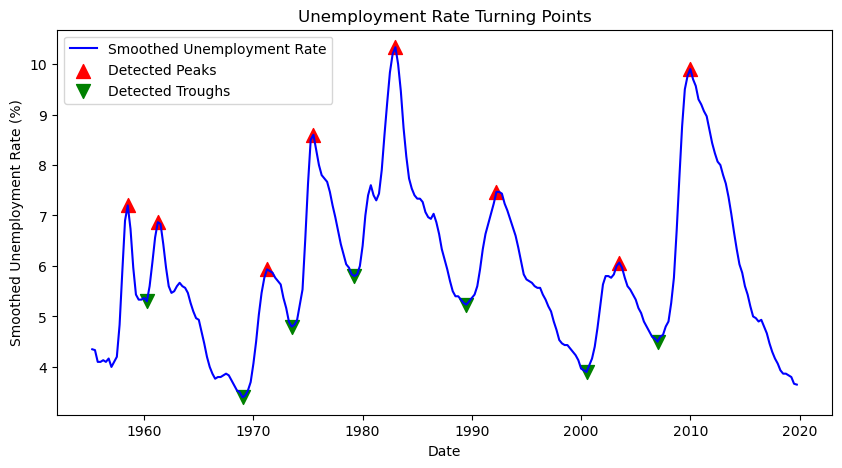

c:\Users\wrc938\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\wrc938\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
c:\Users\wrc938\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
c:\Users\wrc938\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest i


Detected GDP Peaks (log scale, using prominence):
            logy_smooth
Date                   
1957-04-01     8.076752
1973-07-01     8.719688
1979-10-01     8.898380
1981-04-01     8.916189
1990-04-01     9.217705
2008-01-01     9.735095

Detected GDP Troughs (log scale, using prominence):
            logy_smooth
Date                   
1958-01-01     8.056770
1975-01-01     8.698786
1980-07-01     8.885853
1982-04-01     8.896789
1991-01-01     9.209673
2009-04-01     9.698790

GDP Cycle Summary (log levels):
  start_trough       peak end_trough  contraction_amp  expansion_amp  \
0   1973-07-01 1975-01-01 1979-10-01        -0.020902      -0.199594   
1   1979-10-01 1980-07-01 1981-04-01        -0.012527      -0.030336   
2   1981-04-01 1982-04-01 1990-04-01        -0.019400      -0.320917   

   contraction_duration_quarters  expansion_duration_quarters  
0                       6.012320                    18.989733  
1                       3.000684                     3.000684 

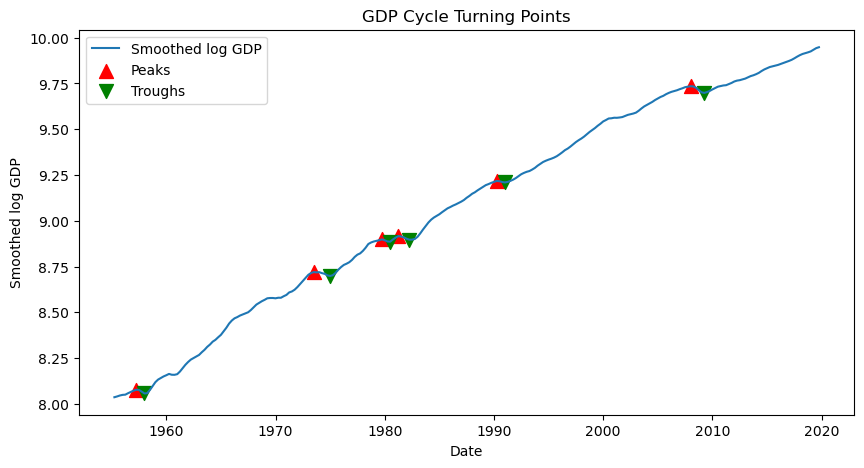

In [ ]:

"""
Empirical Analysis Replicating the Plucking Model of Business Cycles
---------------------------------------------------------------------
This script:
    1. Loads a quarterly dataset (with columns including Date, 'u' for unemployment rate, and 'y' for GDP).
    2. Preprocesses the data (date parsing, subsetting sample to 1955–2019, smoothing).
    3. Identifies business-cycle turning points (peaks and troughs) in the unemployment rate using a prominence threshold 
       (to ignore small “blips”, as in the paper’s method). Then, only the turning points from the third to the third-last
       are retained (forcing the third and third-last to be troughs for cycle anchoring).
    4. Computes cycle amplitudes (contraction: trough -> peak, expansion: peak -> next trough).
    5. Runs regressions to test the plucking property:
         - Regression 1: Regress expansion amplitude (of cycle i) on contraction amplitude (of cycle i).
         - Regression 2: Regress contraction amplitude (of cycle i+1) on expansion amplitude (of cycle i).
    6. Computes cycle speed (annualized rate of change) and duration for expansions and contractions.
    7. Computes skewness of the unemployment rate.
    8. Repeats analogous analyses for GDP data.
    
Libraries used: pandas, numpy, matplotlib, scipy, statsmodels.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew
import statsmodels.api as sm

# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------
data_path = 'data.csv'  # Adjust the file path if needed.
df = pd.read_csv(data_path, parse_dates=['Date'])  # Assumes the CSV has a 'Date' column.
df.set_index('Date', inplace=True)

# Restrict sample to 1955–2019 (adjust dates as needed)
df = df['1955-01-01':'2019-12-31'].copy()

# Create log GDP (useful for growth calculations later)
df['logy'] = np.log(df['y'])

print("Data sample:")
print(df.head())

# ---------------------------
# 2. Smoothing the Unemployment Rate
# ---------------------------
# Apply a 3-quarter moving average to filter out high-frequency noise.
# We use min_periods=1 to ensure that boundary observations are computed.
df['u_smooth'] = df['u'].rolling(window=3, center=True, min_periods=1).mean()

# ---------------------------
# 3. Detect Turning Points in Unemployment (Using Prominence)
# ---------------------------
# Use a minimum prominence threshold to ignore small "blips" – matching the paper’s method.
prominence_threshold = 0.5  # (in percentage points); adjust as needed.
peak_indices, _ = find_peaks(df['u_smooth'].dropna(), prominence=prominence_threshold)
trough_indices, _ = find_peaks(-df['u_smooth'].dropna(), prominence=prominence_threshold)

# Retrieve the corresponding dates and smoothed unemployment values.
peaks = df.iloc[peak_indices][['u_smooth']]
troughs = df.iloc[trough_indices][['u_smooth']]

print("\nDetected Unemployment Peaks (using prominence threshold):")
print(peaks)
print("\nDetected Unemployment Troughs (using prominence threshold):")
print(troughs)

# Combine the detected turning points (both peaks and troughs) and sort by date.
tp_indices = np.sort(np.concatenate([peak_indices, trough_indices]))
tp_dates = df.index[tp_indices]
tp_values = df['u_smooth'].iloc[tp_indices].values

# ----- Trim the turning points: force the boundaries to be the third and third-last turning points -----
# That is, only use the turning points from index 2 (the third) to index -2 (the third-last) inclusive.
tp_dates = tp_dates[2:-2]
tp_values = tp_values[2:-2]

# Print the trimmed turning points for verification.
print("\nTrimmed Unemployment Turning Points (using 3rd to 3rd-last):")
for d, v in zip(tp_dates, tp_values):
    print(f"{d.date()}: {v:.2f}")

# ---------------------------
# 4. Form Business Cycle Phases for Unemployment
# ---------------------------
# Define each cycle as: trough -> peak -> next trough.
# Compute:
#   - Contraction amplitude: increase in unemployment from trough to peak.
#   - Expansion amplitude: decrease in unemployment from peak to following trough.
#   - Duration (in quarters) for each phase.
cycles_u = []
for i in range(0, len(tp_dates)-2, 2):
    trough1_date = tp_dates[i]
    peak_date = tp_dates[i+1]
    trough2_date = tp_dates[i+2]
    
    trough1 = tp_values[i]
    peak = tp_values[i+1]
    trough2 = tp_values[i+2]
    
    contraction_amp = peak - trough1      # Increase (contraction amplitude)
    expansion_amp = peak - trough2         # Decrease (expansion amplitude)
    
    # Calculate durations in quarters (assuming quarterly data).
    contraction_duration = (peak_date - trough1_date).days / 365.25 * 4
    expansion_duration = (trough2_date - peak_date).days / 365.25 * 4
    
    cycles_u.append({
        'start_trough': trough1_date,
        'peak': peak_date,
        'end_trough': trough2_date,
        'contraction_amp': contraction_amp,
        'expansion_amp': expansion_amp,
        'contraction_duration_quarters': contraction_duration,
        'expansion_duration_quarters': expansion_duration
    })

cycles_u_df = pd.DataFrame(cycles_u)
print("\nUnemployment Cycle Summary:")
print(cycles_u_df)

# ---------------------------
# 5. Regression Analysis on Unemployment Cycles
# ---------------------------
# Regression 1: Regress expansion amplitude on the contraction amplitude of the same cycle.
# Hypothesis: Under the plucking model, a larger contraction should yield a larger subsequent expansion (slope near 1).
X1 = cycles_u_df['contraction_amp']
y1 = cycles_u_df['expansion_amp']
X1 = sm.add_constant(X1)  # Add an intercept term.
model1 = sm.OLS(y1, X1, missing='drop').fit()
print("\nRegression: Expansion Amplitude on Contraction Amplitude (Unemployment)")
print(model1.summary())
# A significant slope (ideally close to 1) supports the plucking hypothesis.

# Regression 2: Regress the contraction amplitude of the next cycle on the expansion amplitude of the current cycle.
# Hypothesis: The expansion amplitude of one cycle should not predict the contraction amplitude of the subsequent cycle.
X2 = cycles_u_df['expansion_amp'][:-1].reset_index(drop=True)
y2 = cycles_u_df['contraction_amp'][1:].reset_index(drop=True)
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2, missing='drop').fit()
print("\nRegression: Next Cycle Contraction Amplitude on Current Cycle Expansion Amplitude (Unemployment)")
print(model2.summary())
# A non-significant coefficient here is consistent with the plucking property.

# ---------------------------
# 6. Calculate Speed (Annualized Change) and Duration for Unemployment Phases
# ---------------------------
# Annualized speed is defined as amplitude divided by phase duration (converted to years).
cycles_u_df['contraction_speed'] = cycles_u_df['contraction_amp'] / (cycles_u_df['contraction_duration_quarters'] / 4)
cycles_u_df['expansion_speed'] = cycles_u_df['expansion_amp'] / (cycles_u_df['expansion_duration_quarters'] / 4)

print("\nUnemployment Cycle Speeds (percentage points per year):")
print(cycles_u_df[['contraction_speed', 'expansion_speed']])
# Typically, contractions are steeper (faster) than expansions.

# ---------------------------
# 7. Compute Skewness of Unemployment Rate Distribution
# ---------------------------
# Skewness quantifies the asymmetry of the distribution.
# A positive skew indicates occasional high unemployment spikes.
u_skew = skew(df['u'].dropna())
print("\nSkewness of Unemployment Rate:", u_skew)
# This tests whether the unemployment rate distribution is right-skewed, as predicted by the plucking model.

# ---------------------------
# 11. Plot Unemployment Rate Turning Points
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['u_smooth'], label='Smoothed Unemployment Rate', color='blue')
plt.scatter(peaks.index, peaks['u_smooth'], color='red', marker='^', s=100, label='Detected Peaks')
plt.scatter(troughs.index, troughs['u_smooth'], color='green', marker='v', s=100, label='Detected Troughs')
plt.xlabel("Date")
plt.ylabel("Smoothed Unemployment Rate (%)")
plt.title("Unemployment Rate Turning Points")
plt.legend()
plt.show()
# This figure shows the smoothed unemployment rate with the originally detected turning points.

# ---------------------------
# 9. Repeat Analysis for GDP
# ---------------------------
# For GDP, we use the log level (commonly used for detrended output).
# First, smooth the log GDP series. Use min_periods=1 to avoid boundary NaNs.
df['logy_smooth'] = df['logy'].rolling(window=3, center=True, min_periods=1).mean()

# Detect peaks and troughs in the smoothed log GDP series using a prominence threshold.
gdp_prominence = 0.005  # Adjust as appropriate for log levels.
gdp_peak_indices, _ = find_peaks(df['logy_smooth'].dropna(), prominence=gdp_prominence)
gdp_trough_indices, _ = find_peaks(-df['logy_smooth'].dropna(), prominence=gdp_prominence)

gdp_peaks = df.iloc[gdp_peak_indices][['logy_smooth']]
gdp_troughs = df.iloc[gdp_trough_indices][['logy_smooth']]

print("\nDetected GDP Peaks (log scale, using prominence):")
print(gdp_peaks)
print("\nDetected GDP Troughs (log scale, using prominence):")
print(gdp_troughs)

# Form cycles for GDP: trough -> peak -> next trough.
cycles_gdp = []
tp_indices_gdp = np.sort(np.concatenate([gdp_peak_indices, gdp_trough_indices]))
tp_dates_gdp = df.index[tp_indices_gdp]
tp_values_gdp = df['logy_smooth'].iloc[tp_indices_gdp].values

# For GDP, force the turning points to run from the third to the third-last.
tp_dates_gdp = tp_dates_gdp[2:-2]
tp_values_gdp = tp_values_gdp[2:-2]

for i in range(0, len(tp_dates_gdp)-2, 2):
    trough1_date = tp_dates_gdp[i]
    peak_date = tp_dates_gdp[i+1]
    trough2_date = tp_dates_gdp[i+2]
    
    trough1 = tp_values_gdp[i]
    peak = tp_values_gdp[i+1]
    trough2 = tp_values_gdp[i+2]
    
    contraction_amp = peak - trough1  # Increase (in log terms) from trough to peak.
    expansion_amp = peak - trough2     # Decline from peak to trough (output recovery).
    
    contraction_duration = (peak_date - trough1_date).days / 365.25 * 4  # in quarters.
    expansion_duration = (trough2_date - peak_date).days / 365.25 * 4
    
    cycles_gdp.append({
        'start_trough': trough1_date,
        'peak': peak_date,
        'end_trough': trough2_date,
        'contraction_amp': contraction_amp,
        'expansion_amp': expansion_amp,
        'contraction_duration_quarters': contraction_duration,
        'expansion_duration_quarters': expansion_duration
    })

cycles_gdp_df = pd.DataFrame(cycles_gdp)
print("\nGDP Cycle Summary (log levels):")
print(cycles_gdp_df)

# ---------------------------
# GDP Regressions
# ---------------------------
# Regression 1 for GDP: Test if a larger GDP contraction (drop in log output) predicts a larger recovery.
X1_gdp = cycles_gdp_df['contraction_amp']
y1_gdp = cycles_gdp_df['expansion_amp']
X1_gdp = sm.add_constant(X1_gdp)
model1_gdp = sm.OLS(y1_gdp, X1_gdp, missing='drop').fit()
print("\nGDP Regression: Expansion Amplitude on Contraction Amplitude (log scale)")
print(model1_gdp.summary())
# A slope near 1 would suggest a one-for-one recovery; however, trend growth often causes output to exceed previous peaks.

# Regression 2 for GDP: Regress the contraction amplitude of the next cycle on the expansion amplitude of the current cycle.
X2_gdp = cycles_gdp_df['expansion_amp'][:-1].reset_index(drop=True)
y2_gdp = cycles_gdp_df['contraction_amp'][1:].reset_index(drop=True)
X2_gdp = sm.add_constant(X2_gdp)
model2_gdp = sm.OLS(y2_gdp, X2_gdp, missing='drop').fit()
print("\nGDP Regression: Next Cycle Contraction Amplitude on Current Cycle Expansion Amplitude (log scale)")
print(model2_gdp.summary())
# We generally do not expect a significant predictive relationship here.

# ---------------------------
# Calculate GDP Cycle Speeds
# ---------------------------
cycles_gdp_df['contraction_speed'] = cycles_gdp_df['contraction_amp'] / (cycles_gdp_df['contraction_duration_quarters'] / 4)
cycles_gdp_df['expansion_speed'] = cycles_gdp_df['expansion_amp'] / (cycles_gdp_df['expansion_duration_quarters'] / 4)
print("\nGDP Cycle Speeds (log points per year):")
print(cycles_gdp_df[['contraction_speed', 'expansion_speed']])

# ---------------------------
# Compute Skewness for Quarterly Log GDP Growth
# ---------------------------
df['logy_growth'] = df['logy'].diff()  # Quarterly change in log GDP approximates percentage change.
gdp_growth_skew = skew(df['logy_growth'].dropna())
print("\nSkewness of Quarterly Log GDP Growth:", gdp_growth_skew)
# This tests for asymmetry in GDP growth (e.g., heavier negative tails during recessions).

# ---------------------------
# Plot GDP Cycle Turning Points
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['logy_smooth'], label='Smoothed log GDP')
plt.scatter(gdp_peaks.index, gdp_peaks['logy_smooth'], color='red', marker='^', s=100, label='Peaks')
plt.scatter(gdp_troughs.index, gdp_troughs['logy_smooth'], color='green', marker='v', s=100, label='Troughs')
plt.xlabel("Date")
plt.ylabel("Smoothed log GDP")
plt.title("GDP Cycle Turning Points")
plt.legend()
plt.show()
# This figure displays the turning points in log GDP (output) as defined by the prominence-filtered peaks and troughs.
